In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os


zip_path = "/content/drive/MyDrive/hosp1.zip"
extract_path = "/content/dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: /content/dataset


In [ ]:
!pip -q install pandas matplotlib scikit-learn

import os, re, gc, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

pd.set_option('display.max_columns', 120)

ROOT = "/content/dataset/hosp1"

In [ ]:
import pandas as pd
import os

ROOT = "/content/dataset/hosp1"
files = [f for f in os.listdir(ROOT) if f.endswith(".csv.gz")]

print(f"Found {len(files)} hosp CSV files:")
for f in files:
    print("-", f)

Found 12 hosp CSV files:
- provider.csv.gz
- drgcodes.csv.gz
- procedures_icd.csv.gz
- d_icd_diagnoses.csv.gz
- prescriptions.csv.gz
- diagnoses_icd.csv.gz
- admissions.csv.gz
- d_labitems.csv.gz
- labevents.csv.gz
- pharmacy.csv.gz
- d_icd_procedures.csv.gz
- patients.csv.gz


In [ ]:
for file in files:
    path = os.path.join(ROOT, file)
    print("\n=== Reading:", file, "===")
    try:
        # Only load first 5 rows to avoid heavy memory usage
        df = pd.read_csv(path, nrows=5)
        print(f"Shape (first 5 rows): {df.shape}")
        print("Columns:", list(df.columns))
    except Exception as e:
        print(f"Error reading {file}: {e}")


=== Reading: provider.csv.gz ===
Shape (first 5 rows): (5, 1)
Columns: ['provider_id']

=== Reading: drgcodes.csv.gz ===
Shape (first 5 rows): (5, 7)
Columns: ['subject_id', 'hadm_id', 'drg_type', 'drg_code', 'description', 'drg_severity', 'drg_mortality']

=== Reading: procedures_icd.csv.gz ===
Shape (first 5 rows): (5, 6)
Columns: ['subject_id', 'hadm_id', 'seq_num', 'chartdate', 'icd_code', 'icd_version']

=== Reading: d_icd_diagnoses.csv.gz ===
Shape (first 5 rows): (5, 3)
Columns: ['icd_code', 'icd_version', 'long_title']

=== Reading: prescriptions.csv.gz ===
Shape (first 5 rows): (5, 21)
Columns: ['subject_id', 'hadm_id', 'pharmacy_id', 'poe_id', 'poe_seq', 'order_provider_id', 'starttime', 'stoptime', 'drug_type', 'drug', 'formulary_drug_cd', 'gsn', 'ndc', 'prod_strength', 'form_rx', 'dose_val_rx', 'dose_unit_rx', 'form_val_disp', 'form_unit_disp', 'doses_per_24_hrs', 'route']

=== Reading: diagnoses_icd.csv.gz ===
Shape (first 5 rows): (5, 5)
Columns: ['subject_id', 'hadm_id'

In [ ]:
# admissions
adm_cols =  ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
            'admission_type', 'admit_provider_id', 'admission_location',
            'discharge_location', 'insurance', 'language', 'marital_status',
            'race', 'edregtime', 'edouttime', 'hospital_expire_flag']
admissions = pd.read_csv(
    f"{ROOT}/admissions.csv.gz",
    usecols=adm_cols,
    parse_dates=["admittime","dischtime","deathtime","edregtime","edouttime"]
)
admissions["admit_year"] = admissions["admittime"].dt.year



In [ ]:
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,admit_year
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,2180
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0,2180
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0,2180
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0,2180
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,English,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0,2160


In [ ]:
# diagnoses
diagnoses_icd = pd.read_csv(
    f"{ROOT}/diagnoses_icd.csv.gz",
    usecols = ['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version']
)
d_icd = pd.read_csv(f"{ROOT}/d_icd_diagnoses.csv.gz",
                    usecols = ['icd_code', 'icd_version', 'long_title'])

In [ ]:
diagnoses_icd.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [ ]:
d_icd.head()

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


In [ ]:
# lab
d_labitems = pd.read_csv(f"{ROOT}/d_labitems.csv.gz",
                         usecols = ['itemid', 'label', 'fluid', 'category'])

In [ ]:
d_labitems.head(30)

,itemid,label,fluid,category
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas
1,50802,Base Excess,Blood,Blood Gas
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
3,50804,Calculated Total CO2,Blood,Blood Gas
4,50805,Carboxyhemoglobin,Blood,Blood Gas
5,50806,"Chloride, Whole Blood",Blood,Blood Gas
6,50808,Free Calcium,Blood,Blood Gas
7,50809,Glucose,Blood,Blood Gas
8,50810,"Hematocrit, Calculated",Blood,Blood Gas
9,50811,Hemoglobin,Blood,Blood Gas


In [ ]:
import gzip, io, pandas as pd

lab_ev = f"{ROOT}/labevents.csv.gz"
n = 5

with gzip.open(lab_ev, "rt") as f:
    header = f.readline()
    rows = [f.readline() for _ in range(n)]

preview_df = pd.read_csv(io.StringIO(header + "".join(rows)))
print(preview_df.shape)
print(list(preview_df.columns))
preview_df.head()

(5, 16)
['labevent_id', 'subject_id', 'hadm_id', 'specimen_id', 'itemid', 'order_provider_id', 'charttime', 'storetime', 'value', 'valuenum', 'valueuom', 'ref_range_lower', 'ref_range_upper', 'flag', 'priority', 'comments']


,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,1,10000032,NaN,2704548,50931,P69FQC,2180-03-23 11:51:00,2180-03-23 15:56:00,___,95.0,mg/dL,70.0,100.0,NaN,ROUTINE,"IF FASTING, 70-100 NORMAL, >125 PROVISIONAL DI..."
1,2,10000032,NaN,36092842,51071,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN
2,3,10000032,NaN,36092842,51074,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN
3,4,10000032,NaN,36092842,51075,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,BENZODIAZEPINE IMMUNOASSAY SCREEN DOES NOT DET...
4,5,10000032,NaN,36092842,51079,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN


In [ ]:
# drug codes
drgcodes = pd.read_csv(f"{ROOT}/drgcodes.csv.gz",
                         usecols = ['subject_id', 'hadm_id', 'drg_type', 'drg_code', 'description', 'drg_severity', 'drg_mortality'])

In [ ]:
drgcodes.head()

,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
0,10000032,22595853,APR,283,OTHER DISORDERS OF THE LIVER,2.0,2.0
1,10000032,22595853,HCFA,442,"DISORDERS OF LIVER EXCEPT MALIG,CIRR,ALC HEPA ...",NaN,NaN
2,10000032,22841357,APR,279,HEPATIC COMA AND OTHER MAJOR ACUTE LIVER DISOR...,3.0,2.0
3,10000032,22841357,HCFA,442,"DISORDERS OF LIVER EXCEPT MALIG,CIRR,ALC HEPA ...",NaN,NaN
4,10000032,25742920,APR,283,OTHER DISORDERS OF THE LIVER,3.0,2.0


In [ ]:
# procedures
procedures = pd.read_csv(f"{ROOT}/procedures_icd.csv.gz",
                    usecols = ['subject_id', 'hadm_id', 'seq_num',
                               'chartdate', 'icd_code', 'icd_version'])

d_icd_pr = pd.read_csv(f"{ROOT}/d_icd_procedures.csv.gz",
                    usecols = ['icd_code', 'icd_version', 'long_title'])

In [ ]:
procedures.head()

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version
0,10000032,22595853,1,2180-05-07,5491,9
1,10000032,22841357,1,2180-06-27,5491,9
2,10000032,25742920,1,2180-08-06,5491,9
3,10000068,25022803,1,2160-03-03,8938,9
4,10000117,27988844,1,2183-09-19,0QS734Z,10


In [ ]:
# patients
patients = pd.read_csv(f"{ROOT}/patients.csv.gz",
                    usecols = ['subject_id', 'gender', 'anchor_age',
                               'anchor_year', 'anchor_year_group', 'dod'])

In [ ]:
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000058,F,33,2168,2020 - 2022,NaN
3,10000068,F,19,2160,2008 - 2010,NaN
4,10000084,M,72,2160,2017 - 2019,2161-02-13


In [ ]:
import gzip, io, pandas as pd

pharmacy = f"{ROOT}/pharmacy.csv.gz"
n = 5

with gzip.open(pharmacy, "rt") as f:
    header = f.readline()
    rows = [f.readline() for _ in range(n)]

preview_df = pd.read_csv(io.StringIO(header + "".join(rows)))
print(preview_df.shape)
print(list(preview_df.columns))
preview_df.head()

(5, 27)
['subject_id', 'hadm_id', 'pharmacy_id', 'poe_id', 'starttime', 'stoptime', 'medication', 'proc_type', 'status', 'entertime', 'verifiedtime', 'route', 'frequency', 'disp_sched', 'infusion_type', 'sliding_scale', 'lockout_interval', 'basal_rate', 'one_hr_max', 'doses_per_24_hrs', 'duration', 'duration_interval', 'expiration_value', 'expiration_unit', 'expirationdate', 'dispensation', 'fill_quantity']


,subject_id,hadm_id,pharmacy_id,poe_id,starttime,stoptime,medication,proc_type,status,entertime,verifiedtime,route,frequency,disp_sched,infusion_type,sliding_scale,lockout_interval,basal_rate,one_hr_max,doses_per_24_hrs,duration,duration_interval,expiration_value,expiration_unit,expirationdate,dispensation,fill_quantity
0,10000032,22595853,12775705,10000032-55,2180-05-08 08:00:00,2180-05-07 22:00:00,Furosemide,Unit Dose,Discontinued via patient discharge,2180-05-07 09:32:35,2180-05-07 09:32:35,PO/NG,DAILY,08,NaN,NaN,NaN,NaN,NaN,1,NaN,Ongoing,36,Hours,NaN,Omnicell,NaN
1,10000032,22595853,18415984,10000032-42,2180-05-07 02:00:00,2180-05-07 22:00:00,Ipratropium Bromide Neb,Unit Dose,Discontinued via patient discharge,2180-05-07 01:49:23,2180-05-07 01:49:23,IH,Q6H,"2, 8, 14, 20",NaN,NaN,NaN,NaN,NaN,4,NaN,Ongoing,36,Hours,NaN,Omnicell,NaN
2,10000032,22595853,23637373,10000032-35,2180-05-07 01:00:00,2180-05-07 09:00:00,Furosemide,Unit Dose,Inactive (Due to a change order),2180-05-07 00:09:24,2180-05-07 00:09:24,PO/NG,DAILY,08,NaN,NaN,NaN,NaN,NaN,1,NaN,Ongoing,36,Hours,NaN,Omnicell,NaN
3,10000032,22595853,26862314,10000032-41,2180-05-07 01:00:00,2180-05-07 01:00:00,Potassium Chloride,Unit Dose,Discontinued,2180-05-07 00:09:24,2180-05-07 00:09:24,PO,ONCE,1,NaN,NaN,NaN,NaN,NaN,1,1.0,Doses,36,Hours,NaN,Omnicell,NaN
4,10000032,22595853,30740602,10000032-27,2180-05-07 00:00:00,2180-05-07 22:00:00,Sodium Chloride 0.9% Flush,Unit Dose,Discontinued via patient discharge,2180-05-07 00:00:54,2180-05-07 00:00:54,IV,Q8H,"0, 8, 16",NaN,NaN,NaN,NaN,NaN,3,NaN,Ongoing,36,Hours,NaN,Floor Stock Item,NaN


In [ ]:
import gzip, io, pandas as pd

prescriptions = f"{ROOT}/prescriptions.csv.gz"
n = 5

with gzip.open(prescriptions, "rt") as f:
    header = f.readline()
    rows = [f.readline() for _ in range(n)]

preview_df = pd.read_csv(io.StringIO(header + "".join(rows)))
print(preview_df.shape)
print(list(preview_df.columns))
preview_df.head()

(5, 21)
['subject_id', 'hadm_id', 'pharmacy_id', 'poe_id', 'poe_seq', 'order_provider_id', 'starttime', 'stoptime', 'drug_type', 'drug', 'formulary_drug_cd', 'gsn', 'ndc', 'prod_strength', 'form_rx', 'dose_val_rx', 'dose_unit_rx', 'form_val_disp', 'form_unit_disp', 'doses_per_24_hrs', 'route']


,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,starttime,stoptime,drug_type,drug,formulary_drug_cd,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10000032,22595853,12775705,10000032-55,55,P85UQ1,2180-05-08 08:00:00,2180-05-07 22:00:00,MAIN,Furosemide,FURO40,8209.0,51079007320,40mg Tablet,NaN,40,mg,1.0,TAB,1,PO/NG
1,10000032,22595853,18415984,10000032-42,42,P23SJA,2180-05-07 02:00:00,2180-05-07 22:00:00,MAIN,Ipratropium Bromide Neb,IPRA2H,21700.0,487980125,2.5mL Vial,NaN,1,NEB,1.0,VIAL,4,IH
2,10000032,22595853,23637373,10000032-35,35,P23SJA,2180-05-07 01:00:00,2180-05-07 09:00:00,MAIN,Furosemide,FURO20,8208.0,51079007220,20mg Tablet,NaN,20,mg,1.0,TAB,1,PO/NG
3,10000032,22595853,26862314,10000032-41,41,P23SJA,2180-05-07 01:00:00,2180-05-07 01:00:00,MAIN,Potassium Chloride,MICROK10,1275.0,245004101,10mEq ER Tablet,NaN,40,mEq,4.0,TAB,1,PO
4,10000032,22595853,30740602,10000032-27,27,P23SJA,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0,10 mL Syringe,NaN,3,mL,0.3,SYR,3,IV


##Data processing & Visualizations

In [ ]:
# First admission per patient
first_idx = admissions.sort_values("admittime").groupby("subject_id", as_index=False).head(1).index
cohort = admissions.loc[first_idx].copy().reset_index(drop=True)

# LOS
cohort["los_hours"] = (cohort["dischtime"] - cohort["admittime"]).dt.total_seconds() / 3600.0
cohort["los_days"]  = cohort["los_hours"] / 24.0

# ED LOS
if {"edregtime","edouttime"}.issubset(cohort.columns):
    mask = cohort["edregtime"].notna() & cohort["edouttime"].notna()
    cohort.loc[mask,"ed_los_hours"] = (
        (cohort.loc[mask,"edouttime"] - cohort.loc[mask,"edregtime"]).dt.total_seconds()/3600.0
    )

hadm_set = set(cohort["hadm_id"].astype(int))
print("Cohort size:", len(cohort))

Cohort size: 223452


In [ ]:
def is_t2d_icd(code, ver):
    if pd.isna(code): return False
    code = str(code)
    if int(ver) == 10:
        return code.startswith("E11")
    if int(ver) == 9 and re.match(r"^250\.[0-9]{2}$", code):
        return code[-1] in {"0","2"}
    return False

dx = diagnoses_icd[diagnoses_icd["hadm_id"].isin(hadm_set)].copy()
dx["is_t2d"] = dx.apply(lambda r: is_t2d_icd(r["icd_code"], r["icd_version"]), axis=1)

t2d_flag = dx.groupby("hadm_id")["is_t2d"].max().astype(int).reset_index()
cohort = cohort.merge(t2d_flag, on="hadm_id", how="left")
cohort["is_t2d"] = cohort["is_t2d"].fillna(0).astype(int)

In [ ]:
import re, numpy as np, pandas as pd, gc

# 1) Make a clean, normalized label column
lab_src = d_labitems.copy()
lab_src["label_l"] = lab_src["label"].str.lower().str.replace(r"\s+", " ", regex=True).str.strip()

# OPTIONAL: narrow to blood chemistry only (avoids urine glucose, etc.)
# lab_src = lab_src[(lab_src["fluid"].str.lower()=="blood") | (lab_src["category"].str.lower().str.contains("chem", na=False))]

# 2) Helper matchers
def contains_any(s: pd.Series, patterns):
    pat = "|".join(patterns)
    return s.str.contains(pat, na=False, regex=True)

def contains_all(s: pd.Series, words):
    m = pd.Series(True, index=s.index)
    for w in words:
        m = m & s.str.contains(w, na=False, regex=True)
    return m

# 3) Robust itemid selection
hba1c_mask = contains_any(
    lab_src["label_l"],
    [r"\bhba1c\b", r"\bhemoglobin a1c\b", r"\bglyco.?hemoglobin\b"]
)

# Glucose (avoid glucose tolerance, urine, CSF, etc. if possible)
glucose_mask = contains_any(lab_src["label_l"], [r"\bglucose\b"])
# If you want to exclude non-blood explicitly:
# glucose_mask = glucose_mask & (lab_src["fluid"].str.lower()=="blood")

# Total cholesterol (ensure both words appear)
chol_total_mask = contains_all(lab_src["label_l"], [r"cholesterol", r"total"])

targets = {
    "hba1c":       lab_src.loc[hba1c_mask, "itemid"].astype(int).unique().tolist(),
    "glucose":     lab_src.loc[glucose_mask, "itemid"].astype(int).unique().tolist(),
    "chol_total":  lab_src.loc[chol_total_mask, "itemid"].astype(int).unique().tolist(),
}

# 4) Debug: print what we matched (very important!)
for name, ids in targets.items():
    print(f"{name}: {len(ids)} itemids")
    if len(ids):
        ex = lab_src.loc[lab_src["itemid"].isin(ids), ["itemid","label","fluid","category"]].head(5)
        display(ex)

# 5) Stream labevents and aggregate per-admission medians
lab_feats = {k:{} for k in targets}
chunksize = 2_000_000
usecols = ["hadm_id","itemid","valuenum"]

for chunk in pd.read_csv(f"{ROOT}/labevents.csv.gz", usecols=usecols, chunksize=chunksize):
    # ensure types are comparable
    chunk = chunk[
        chunk["hadm_id"].isin(hadm_set) &
        chunk["valuenum"].notna() &
        chunk["itemid"].notna()
    ]
    if chunk.empty:
        del chunk; gc.collect(); continue

    # cast itemid to int to match our lists
    chunk["itemid"] = chunk["itemid"].astype(int)

    for analyte, ids in targets.items():
        if not ids:  # skip if no matches found
            continue
        sub = chunk[chunk["itemid"].isin(ids)][["hadm_id","valuenum"]]
        if sub.empty:
            continue
        for h, vals in sub.groupby("hadm_id")["valuenum"]:
            lab_feats[analyte].setdefault(int(h), []).extend(vals.values.tolist())

    del chunk; gc.collect()

# 6) Build the labs DataFrame (median per hadm)
labs_df = pd.DataFrame({"hadm_id": list(hadm_set)})
for analyte, store in lab_feats.items():
    col = f"{analyte}_median"
    labs_df[col] = labs_df["hadm_id"].map(lambda h: np.nanmedian(store[h]) if h in store and len(store[h])>0 else np.nan)
    print(col, " non-null:", labs_df[col].notna().sum())

# 7) Merge back
cohort = cohort.merge(labs_df, on="hadm_id", how="left")

hba1c: 1 itemids


,itemid,label,fluid,category
50,50852,% Hemoglobin A1c,Blood,Chemistry


glucose: 13 itemids


,itemid,label,fluid,category
7,50809,Glucose,Blood,Blood Gas
40,50842,"Glucose, Ascites",Ascites,Chemistry
129,50931,Glucose,Blood,Chemistry
210,51022,"Glucose, Joint Fluid",Joint Fluid,Chemistry
222,51034,"Glucose, Body Fluid",Other Body Fluid,Chemistry


chol_total: 2 itemids


,itemid,label,fluid,category
101,50903,Cholesterol Ratio (Total/HDL),Blood,Chemistry
105,50907,"Cholesterol, Total",Blood,Chemistry


hba1c_median  non-null: 22639
glucose_median  non-null: 158113
chol_total_median  non-null: 16780


In [ ]:
drug_groups = {
    "rx_insulin": r"insulin",
    "rx_metformin": r"\bmetformin\b",
    "rx_sulfonylurea": r"glipizide|glyburide|glimepiride|tolbutamide|chlorpropamide"
}
drug_patterns = {k: re.compile(v, re.I) for k,v in drug_groups.items()}
rx_flags = {k:set() for k in drug_groups}

for chunk in pd.read_csv(f"{ROOT}/prescriptions.csv.gz", usecols=["hadm_id","drug"], chunksize=1_000_000, dtype={"hadm_id":"Int64","drug":"string"}):
    chunk = chunk[chunk["hadm_id"].isin(hadm_set) & chunk["drug"].notna()]
    for k, pat in drug_patterns.items():
        hits = chunk.loc[chunk["drug"].str.contains(pat, na=False), "hadm_id"].dropna().astype(int)
        rx_flags[k].update(hits.tolist())
    del chunk; gc.collect()

rx_df = pd.DataFrame({"hadm_id": list(hadm_set)})
for k in drug_groups:
    rx_df[k] = rx_df["hadm_id"].isin(rx_flags[k]).astype(int)

cohort = cohort.merge(rx_df, on="hadm_id", how="left")


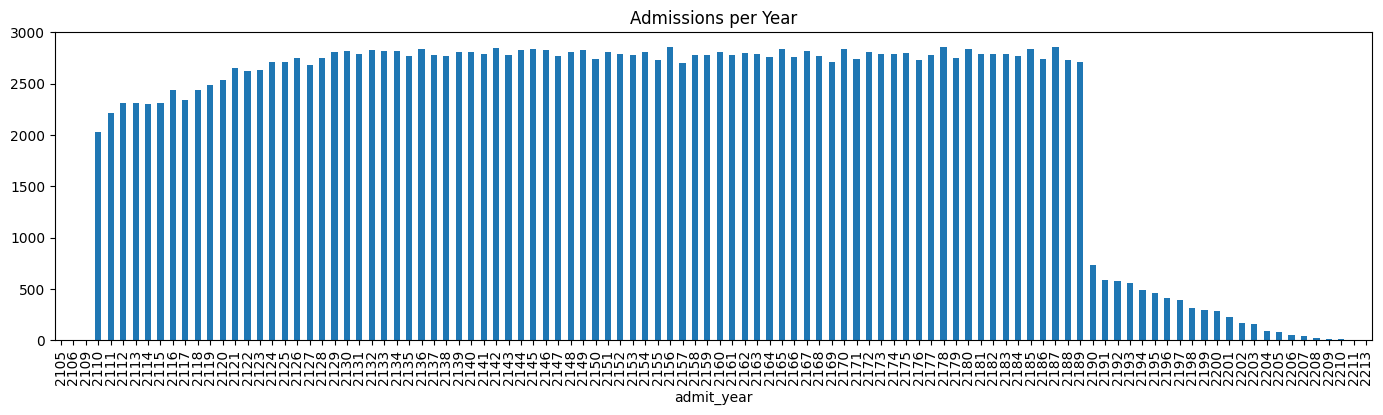

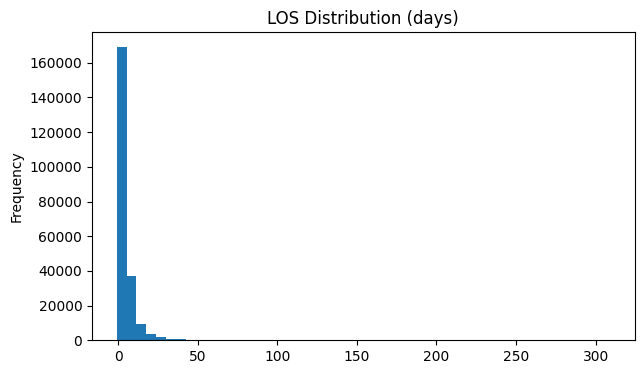

In [ ]:
# ---- Admissions ----
plt.figure(figsize=(17,4))
cohort["admit_year"].value_counts().sort_index().plot(kind="bar")
plt.title("Admissions per Year"); plt.show()

plt.figure(figsize=(7,4))
cohort["los_days"].dropna().plot(kind="hist", bins=50)
plt.title("LOS Distribution (days)"); plt.show()

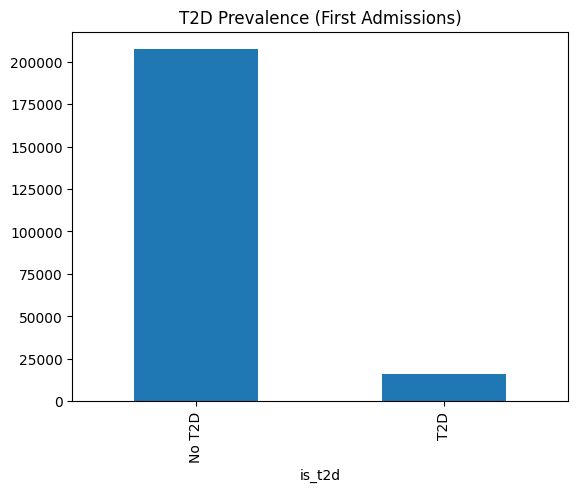

In [ ]:
# ---- T2D prevalence ----
cohort["is_t2d"].map({0:"No T2D",1:"T2D"}).value_counts().plot(kind="bar")
plt.title("T2D Prevalence (First Admissions)"); plt.show()

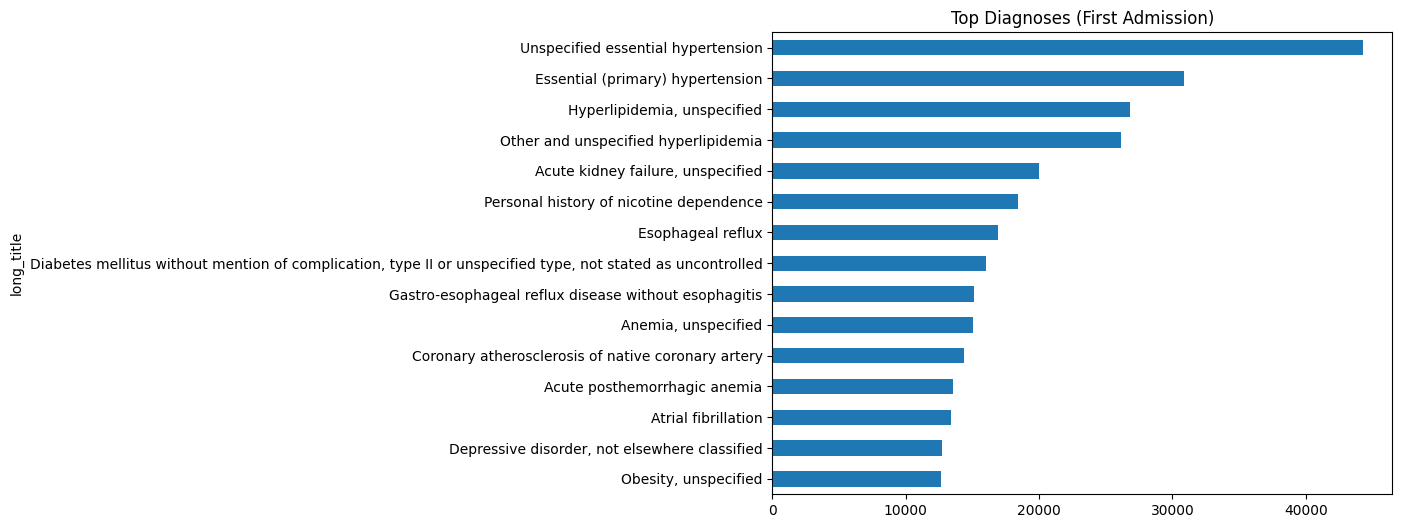

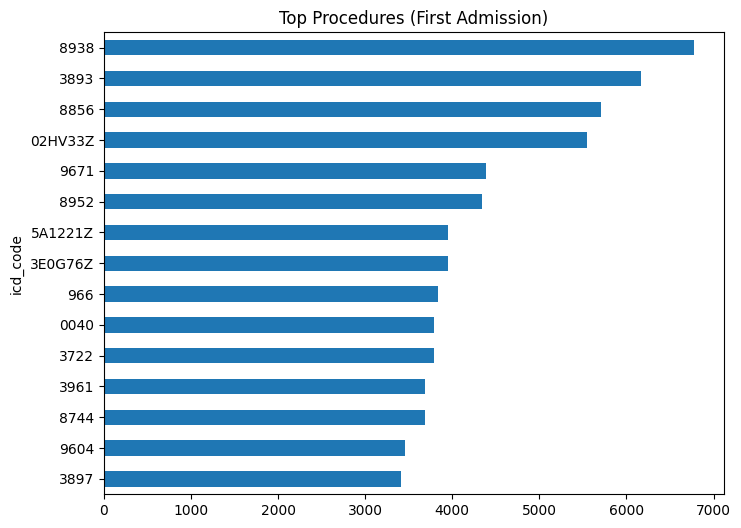

In [ ]:
# ---- Top Diagnoses ----
dx_merge = dx.merge(d_icd, on=["icd_code","icd_version"], how="left")
top_dx = (dx_merge["long_title"].fillna(dx_merge["icd_code"]).value_counts().head(15))
top_dx.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Top Diagnoses (First Admission)"); plt.show()

# ---- Top Procedures ----
proc_first = procedures[procedures["hadm_id"].isin(hadm_set)]
top_proc = proc_first["icd_code"].value_counts().head(15)
top_proc.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Top Procedures (First Admission)"); plt.show()

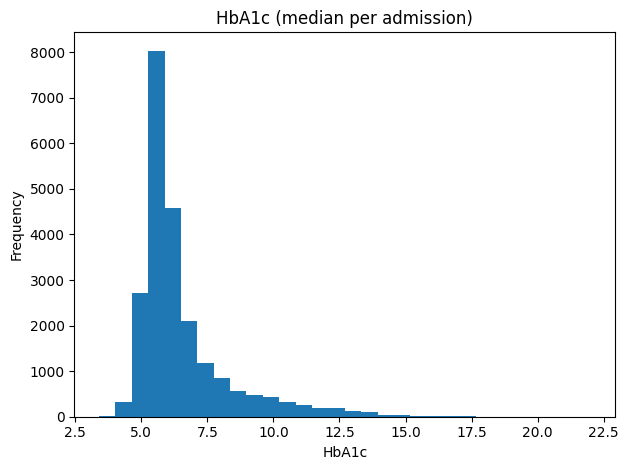

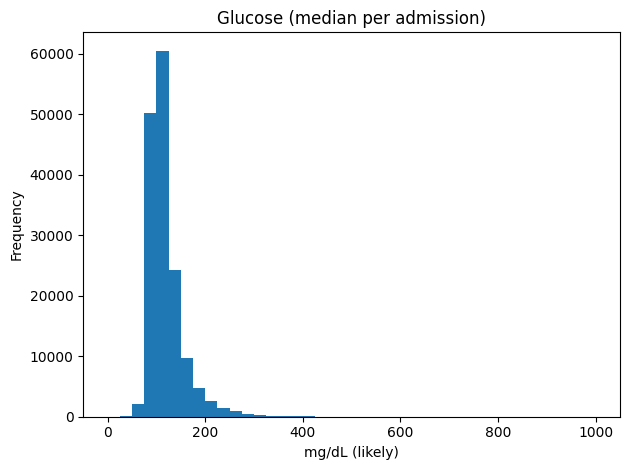

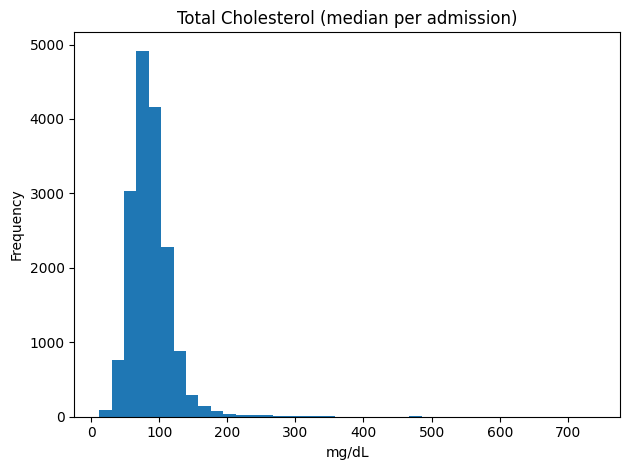

In [ ]:
# 8) Plot with guards (avoid blank plots)
import matplotlib.pyplot as plt

def safe_hist(series, title, bins=30, xlabel=None):
    s = series.dropna()
    if s.empty:
        print(f"[skip] No data to plot for {title}")
        return
    s.plot(kind="hist", bins=bins)
    plt.title(title)
    if xlabel: plt.xlabel(xlabel)
    plt.tight_layout(); plt.show()

safe_hist(cohort["hba1c_median"],   "HbA1c (median per admission)", 30, "HbA1c")
safe_hist(cohort["glucose_median"], "Glucose (median per admission)", 40, "mg/dL (likely)")
safe_hist(cohort["chol_total_median"], "Total Cholesterol (median per admission)", 40, "mg/dL")


In [ ]:
# =========================================================
# Train a T2D classifier from labs (MIMIC-IV v3.1 / hosp)
# =========================================================
!pip -q install pandas scikit-learn matplotlib

import os, re, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, precision_recall_curve

pd.set_option("display.max_columns", 200)

# --------- 0) Paths ---------
ROOT = "/content/dataset/hosp1"   # <-- change to your hosp folder

In [ ]:
# --------- 1) Load small tables ---------
# Admissions (only what's needed)
adm_cols = ["subject_id","hadm_id","admittime","dischtime","hospital_expire_flag"]
admissions = pd.read_csv(
    f"{ROOT}/admissions.csv.gz",
    usecols=adm_cols,
    parse_dates=["admittime","dischtime"]
)

# Diagnoses (for T2D label)
diagnoses_icd = pd.read_csv(
    f"{ROOT}/diagnoses_icd.csv.gz",
    usecols=["subject_id","hadm_id","icd_code","icd_version"]
)

# Lab dictionary (to find itemids by name)
d_labitems = pd.read_csv(
    f"{ROOT}/d_labitems.csv.gz",
    usecols=["itemid","label","fluid","category"]
)

In [ ]:
# --------- 2) First-admission cohort (one row per patient) ---------
first_idx = admissions.sort_values("admittime").groupby("subject_id", as_index=False).head(1).index
cohort = admissions.loc[first_idx].copy().reset_index(drop=True)
cohort["los_days"] = (cohort["dischtime"] - cohort["admittime"]).dt.total_seconds()/86400.0
hadm_set = set(cohort["hadm_id"].astype(int))

In [ ]:
# --------- 3) Create T2D label from ICD-9/10 ---------
def is_t2d_icd(code, ver):
    if pd.isna(code) or pd.isna(ver): return False
    code = str(code)
    ver = int(ver)
    if ver == 10:
        return code.startswith("E11")           # ICD-10 E11.*
    if ver == 9:
        # ICD-9 250.xx where 5th digit in {0,2}
        m = re.match(r"^250\.[0-9]{2}$", code)  # e.g., 250.00, 250.02
        return bool(m) and code[-1] in {"0","2"}
    return False

dx = diagnoses_icd[diagnoses_icd["hadm_id"].isin(hadm_set)].copy()
dx["is_t2d_row"] = dx.apply(lambda r: is_t2d_icd(r["icd_code"], r["icd_version"]), axis=1)
t2d_by_hadm = dx.groupby("hadm_id")["is_t2d_row"].max().astype(int).rename("is_t2d").reset_index()
cohort = cohort.merge(t2d_by_hadm, on="hadm_id", how="left")
cohort["is_t2d"] = cohort["is_t2d"].fillna(0).astype(int)

print("Cohort size:", len(cohort), " | T2D positives:", int(cohort["is_t2d"].sum()))

Cohort size: 223452  | T2D positives: 16203


In [ ]:
# --------- 4) Pick target labs (edit freely) ---------
lab_labels = d_labitems.assign(label_l=d_labitems["label"].str.lower())
TARGET_LABS = {
    "hba1c":         r"hba1c|hemoglobin a1c",
    "glucose":       r"\bglucose\b",
    "chol_total":    r"cholesterol.*total|total.*cholesterol",
    "chol_hdl":      r"\bhdl\b|high density lipoprotein",
    "chol_ldl":      r"\bldl\b|low density lipoprotein",
    "triglycerides": r"triglyceride",
}

target_itemids = {
    name: set(lab_labels.loc[lab_labels["label_l"].str.contains(pattern, na=False), "itemid"].tolist())
    for name, pattern in TARGET_LABS.items()
}

In [ ]:
# --------- 5) Fast earliest-value extraction per admission ---------
# We keep the earliest charttime value per analyte for each hadm (low RAM, one pass)
earliest = {name: {} for name in target_itemids.keys()}

usecols = ["hadm_id","itemid","charttime","valuenum"]
for chunk in pd.read_csv(
    f"{ROOT}/labevents.csv.gz",
    usecols=usecols,
    parse_dates=["charttime"],
    chunksize=500_000
):
    # filter to cohort admissions and valid values
    chunk = chunk[
        chunk["hadm_id"].isin(hadm_set) &
        chunk["valuenum"].notna() &
        chunk["itemid"].notna()
    ]
    if chunk.empty:
        del chunk; gc.collect(); continue

    for name, ids in target_itemids.items():
        if not ids:
            continue
        sub = chunk[chunk["itemid"].isin(ids)][["hadm_id","charttime","valuenum"]]
        if sub.empty:
            continue
        # keep earliest charttime per hadm
        # (process groupwise without storing all rows)
        for hadm, grp in sub.groupby("hadm_id", sort=False):
            idx = grp["charttime"].idxmin()
            t = grp.at[idx, "charttime"]
            v = float(grp.at[idx, "valuenum"])
            rec = earliest[name].get(hadm)
            if (rec is None) or (t < rec[0]):  # earlier than stored
                earliest[name][hadm] = (t, v)

    del chunk; gc.collect()

In [ ]:
# Turn earliest dicts into columns and merge
labs_first = pd.DataFrame({"hadm_id": list(hadm_set)})
for name, store in earliest.items():
    labs_first[f"{name}_first"] = labs_first["hadm_id"].map(lambda h: store[h][1] if h in store else np.nan)

cohort = cohort.merge(labs_first, on="hadm_id", how="left")

# --------- 6) Build features (labs only) + label ---------
lab_cols = [c for c in cohort.columns if c.endswith("_first")]
X = cohort[lab_cols].copy()
y = cohort["is_t2d"].astype(int)

# Drop rows where *all* lab features are missing
row_all_na = X.isna().all(axis=1)
X = X.loc[~row_all_na].reset_index(drop=True)
y = y.loc[~row_all_na].reset_index(drop=True)
print("After dropping all-NA lab rows:", X.shape)

After dropping all-NA lab rows: (158512, 6)


In [ ]:
# --------- 7) Train / test split ---------
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------- 8) Two simple models: Logistic Regression & Random Forest ---------
# Pipeline: median impute -> scale (for LR) -> classifier
lr_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler()),               # centered scaling helps LR
    ("clf",    LogisticRegression(max_iter=500, class_weight="balanced"))
])

rf_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("clf",    RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, class_weight="balanced_subsample", random_state=42
    ))
])

models = {
    "LogReg": lr_pipeline,
    "RandomForest": rf_pipeline
}

results = {}
for name, pipe in models.items():
    pipe.fit(Xtr, ytr)
    proba = pipe.predict_proba(Xte)[:,1]
    pred  = (proba >= 0.5).astype(int)
    results[name] = {
        "AUC": roc_auc_score(yte, proba),
        "AP":  average_precision_score(yte, proba),
        "F1":  f1_score(yte, pred)
    }

print("=== Test Metrics ===")
for k,v in results.items():
    print(f"{k:12s}  AUC: {v['AUC']:.3f} | AP: {v['AP']:.3f} | F1: {v['F1']:.3f}")

=== Test Metrics ===
LogReg        AUC: 0.767 | AP: 0.285 | F1: 0.358
RandomForest  AUC: 0.659 | AP: 0.181 | F1: 0.272


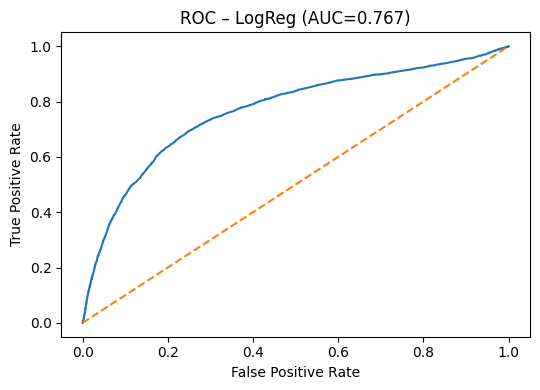

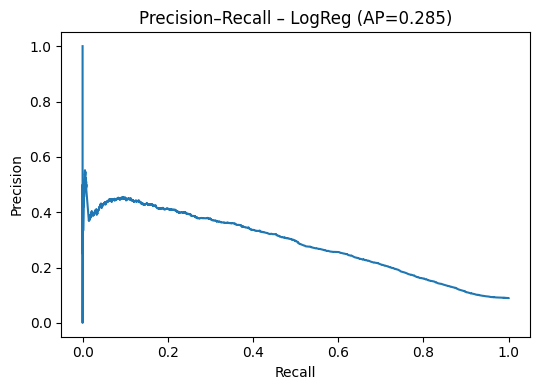

In [ ]:
# --------- 9) Curves (ROC & PR) for the better model ---------
# pick the model with best AUC
best_name = max(results, key=lambda k: results[k]["AUC"])
best = models[best_name]
proba = best.predict_proba(Xte)[:,1]

fpr, tpr, _ = roc_curve(yte, proba)
prec, rec, _ = precision_recall_curve(yte, proba)

plt.figure(figsize=(5.5,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC – {best_name} (AUC={results[best_name]['AUC']:.3f})")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5.5,4))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall – {best_name} (AP={results[best_name]['AP']:.3f})")
plt.tight_layout(); plt.show()

In [ ]:
# --------- 10) Quick feature inspection (LogReg coefficients if chosen) ---------
if best_name == "LogReg":
    # refit steps to access coefficients on imputed+scaled data
    best.fit(Xtr, ytr)
    imputer = best.named_steps["impute"]
    scaler  = best.named_steps["scale"]
    clf     = best.named_steps["clf"]

    Xtr_imp = imputer.transform(Xtr)
    Xtr_std = scaler.transform(Xtr_imp)
    coef = pd.Series(clf.coef_[0], index=X.columns).sort_values(ascending=False)
    print("\nTop positive coefficients (higher -> more likely T2D):")
    display(coef.head(10))
    print("\nTop negative coefficients:")
    display(coef.tail(10))



Top positive coefficients (higher -> more likely T2D):


,0
glucose_first,0.782470
hba1c_first,0.411981
chol_hdl_first,0.037715
triglycerides_first,0.032215
chol_total_first,-0.012876
chol_ldl_first,-0.106172



Top negative coefficients:


,0
glucose_first,0.782470
hba1c_first,0.411981
chol_hdl_first,0.037715
triglycerides_first,0.032215
chol_total_first,-0.012876
chol_ldl_first,-0.106172


In [ ]:
# Test batch + full evaluation for T2D model
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, roc_auc_score, average_precision_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve)

candidate_models = []
for name in ["best", "lr_pipeline", "rf_pipeline"]:
    if name in globals():
        candidate_models.append((name, globals()[name]))

if not candidate_models:
    raise RuntimeError("No trained pipeline found. Train a model first (e.g., 'best', 'lr_pipeline', or 'rf_pipeline').")

model_name, model = candidate_models[0]
print(f"Using model: {model_name}")

Using model: best


In [ ]:
missing_eval_vars = [v for v in ["Xte","yte"] if v not in globals()]
if missing_eval_vars:
    print(f"[warn] Held-out vars not found: {missing_eval_vars}. Skipping full evaluation.")
else:
    proba = model.predict_proba(Xte)[:,1]
    pred  = (proba >= 0.5).astype(int)

    print("\n=== Held-out Test Metrics ===")
    print("Accuracy:", round(accuracy_score(yte, pred), 4))
    print("AUC:     ", round(roc_auc_score(yte, proba), 4))
    print("AP:      ", round(average_precision_score(yte, proba), 4))
    print("F1:      ", round(f1_score(yte, pred), 4))

    print("\nConfusion matrix (thr=0.5):")
    print(confusion_matrix(yte, pred))

    print("\nClassification report:")
    print(classification_report(yte, pred, digits=3))
    plt.tight_layout(); plt.show()


=== Held-out Test Metrics ===
Accuracy: 0.815
AUC:      0.7674
AP:       0.2846
F1:       0.3579

Confusion matrix (thr=0.5):
[[24205  4650]
 [ 1214  1634]]

Classification report:
              precision    recall  f1-score   support

           0      0.952     0.839     0.892     28855
           1      0.260     0.574     0.358      2848

    accuracy                          0.815     31703
   macro avg      0.606     0.706     0.625     31703
weighted avg      0.890     0.815     0.844     31703



<Figure size 640x480 with 0 Axes>

In [ ]:
if "X" not in globals():
    raise RuntimeError("Feature matrix X not found. Keep X from training in memory to build a matching test batch.")

cols = list(X.columns)


def mk_case(**labs):
    row = {c: np.nan for c in cols}

    mapping = {
        "hba1c":        [c for c in cols if c.startswith("hba1c_")],
        "glucose":      [c for c in cols if c.startswith("glucose_")],
        "chol_total":   [c for c in cols if c.startswith("chol_total_")],
        "chol_hdl":     [c for c in cols if c.startswith("chol_hdl_")],
        "chol_ldl":     [c for c in cols if c.startswith("chol_ldl_")],
        "triglycerides":[c for c in cols if c.startswith("triglycerides_")],
    }
    for k, v in labs.items():
        if k in mapping and mapping[k]:
            for col in mapping[k]:
                row[col] = v
    return row

batch_rows = [
    mk_case(hba1c=5.2, glucose=70,  chol_total=150, chol_hdl=55, chol_ldl=95,  triglycerides=110),  # low-ish risk
    mk_case(hba1c=5.7, glucose=100, chol_total=185, chol_hdl=50, chol_ldl=110, triglycerides=140),  # borderline A1c
    mk_case(hba1c=6.1, glucose=115, chol_total=200, chol_hdl=45, chol_ldl=125, triglycerides=160),  # prediabetes-ish
    mk_case(hba1c=6.5, glucose=135, chol_total=210, chol_hdl=40, chol_ldl=140, triglycerides=180),  # threshold A1c
    mk_case(hba1c=7.2, glucose=160, chol_total=220, chol_hdl=38, chol_ldl=150, triglycerides=220),  # likely T2D
    mk_case(hba1c=8.5, glucose=220, chol_total=240, chol_hdl=35, chol_ldl=165, triglycerides=300),  # high risk
    mk_case(hba1c=np.nan, glucose=105, chol_total=180, chol_hdl=55, chol_ldl=95, triglycerides=120), # missing A1c
    mk_case(hba1c=6.8, glucose=np.nan, chol_total=210, chol_hdl=42, chol_ldl=135, triglycerides=210),# missing glucose
]

test_batch = pd.DataFrame(batch_rows, columns=cols)

In [ ]:
proba_batch = model.predict_proba(test_batch)[:,1]
pred_batch  = (proba_batch >= 0.5).astype(int)

out = test_batch.copy()
out.insert(0, "pred_proba", proba_batch.round(4))
out.insert(1, "pred_label", pred_batch)
print("\n=== Test batch predictions (top) ===")
display(out.head(8))


=== Test batch predictions (top) ===


,pred_proba,pred_label,hba1c_first,glucose_first,chol_total_first,chol_hdl_first,chol_ldl_first,triglycerides_first
0,0.4820,0,5.2,70.0,150,55,95,110
1,0.5580,1,5.7,100.0,185,50,110,140
2,0.5861,1,6.1,115.0,200,45,125,160
3,0.6277,1,6.5,135.0,210,40,140,180
4,0.7402,1,7.2,160.0,220,38,150,220
5,0.9013,1,8.5,220.0,240,35,165,300
6,0.6579,1,NaN,105.0,180,55,95,120
7,0.6273,1,6.8,NaN,210,42,135,210


In [ ]:
def evaluate_at_threshold(y_true, y_scores, thr):
    yhat = (y_scores >= thr).astype(int)
    return {
        "thr": thr,
        "acc": accuracy_score(y_true, yhat),
        "f1":  f1_score(y_true, yhat),
        "auc": roc_auc_score(y_true, y_scores),
        "ap":  average_precision_score(y_true, y_scores)
    }

if "Xte" in globals() and "yte" in globals():
    pb = model.predict_proba(Xte)[:,1]
    grid = [0.20, 0.30, 0.40, 0.50, 0.60]
    print("\nThreshold sweep on held-out set:")
    for t in grid:
        m = evaluate_at_threshold(yte, pb, t)
        print(f"thr={t:.2f}  acc={m['acc']:.3f}  f1={m['f1']:.3f}  AUC={m['auc']:.3f}  AP={m['ap']:.3f}")


Threshold sweep on held-out set:
thr=0.20  acc=0.094  f1=0.165  AUC=0.767  AP=0.285
thr=0.30  acc=0.136  f1=0.168  AUC=0.767  AP=0.285
thr=0.40  acc=0.594  f1=0.263  AUC=0.767  AP=0.285
thr=0.50  acc=0.815  f1=0.358  AUC=0.767  AP=0.285
thr=0.60  acc=0.876  f1=0.364  AUC=0.767  AP=0.285


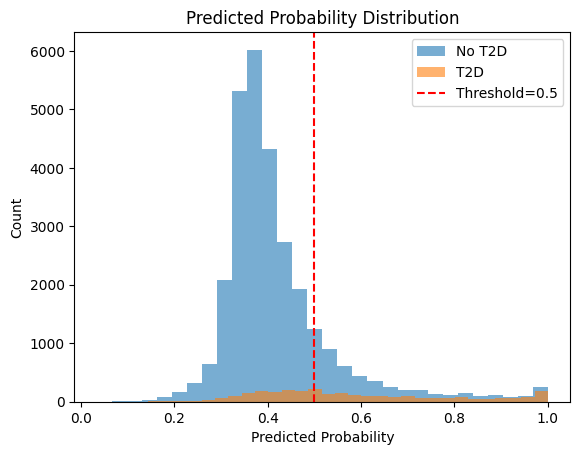

In [ ]:
import matplotlib.pyplot as plt

if "Xte" in globals() and "yte" in globals():
    proba = model.predict_proba(Xte)[:,1]
    plt.hist(proba[yte==0], bins=30, alpha=0.6, label="No T2D")
    plt.hist(proba[yte==1], bins=30, alpha=0.6, label="T2D")
    plt.axvline(0.5, color="red", linestyle="--", label="Threshold=0.5")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.title("Predicted Probability Distribution")
    plt.legend()
    plt.show()

In [ ]:
import joblib, os

OUT_DIR = "/content/saved_model"
os.makedirs(OUT_DIR, exist_ok=True)

MODEL_PATH = os.path.join(OUT_DIR, "t2d_lab_model.joblib")

joblib.dump(model, MODEL_PATH)
print("Model saved to:", MODEL_PATH)

Model saved to: /content/saved_model/t2d_lab_model.joblib


In [ ]:
!pip -q install gradio

import gradio as gr
import numpy as np
import pandas as pd
import joblib

model = joblib.load(MODEL_PATH)
feature_cols = list(X.columns)

def predict_t2d(hba1c, glucose, chol_total, chol_hdl, chol_ldl, triglycerides):
    row = pd.DataFrame([{
        "hba1c_first": hba1c,
        "glucose_first": glucose,
        "chol_total_first": chol_total,
        "chol_hdl_first": chol_hdl,
        "chol_ldl_first": chol_ldl,
        "triglycerides_first": triglycerides
    }])
    for c in feature_cols:
        if c not in row.columns:
            row[c] = np.nan
    row = row[feature_cols]

    proba = model.predict_proba(row)[:, 1][0]

    if proba < 0.40:
        category = "Low risk — maintain a healthy lifestyle"
    elif proba < 0.65:
        category = "Mild risk — consider consulting a specialist"
    else:
        category = "High risk — seek medical advice promptly"

    return {
        "Risk Probability": f"{proba:.1%}",
        "Risk Category": category
    }

demo = gr.Interface(
    fn=predict_t2d,
    inputs=[
        gr.Number(label="HbA1c (e.g. 5.8)", value=5.6),
        gr.Number(label="Glucose (mg/dL)", value=100),
        gr.Number(label="Total Cholesterol (mg/dL)", value=180),
        gr.Number(label="HDL (mg/dL)", value=50),
        gr.Number(label="LDL (mg/dL)", value=110),
        gr.Number(label="Triglycerides (mg/dL)", value=140),
    ],
    outputs="json",
    title="Type 2 Diabetes Risk Predictor",
    description="Enter lab results and get a risk score with color-coded category"
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://36480b86741816c08c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip -q install fastapi uvicorn shap joblib scikit-learn numpy pandas

import os, joblib, numpy as np, pandas as pd, shap
from fastapi import FastAPI
from pydantic import BaseModel, Field
from typing import List, Optional, Dict

# === Load your trained pipeline ===
MODEL_PATH = "/content/saved_model/t2d_lab_model.joblib"  # set this
model = joblib.load(MODEL_PATH)

# Keep training feature order
try:
    feature_cols = list(X.columns)   # if X is still in memory
except:
    # put the exact lab columns you trained on:
    feature_cols = [
        "hba1c_first","glucose_first",
        "chol_total_first","chol_hdl_first","chol_ldl_first","triglycerides_first"
    ]

# SHAP explainer (tree -> TreeExplainer; logistic/svm -> KernelExplainer)
# Works for typical sklearn pipelines (imputer/scale/clf)
# Build a tiny background for KernelExplainer for speed:
bg = pd.DataFrame([{c: np.nan for c in feature_cols}])  # imputer handles NaN baseline
explainer = shap.KernelExplainer(lambda X_: model.predict_proba(pd.DataFrame(X_, columns=feature_cols))[:,1],
                                 bg, link="logit")

LOW = 0.40
HIGH = 0.65

def categorize(p: float) -> str:
    if p < LOW:  return "low"
    if p < HIGH: return "mild"
    return "high"

def align_row(d: Dict[str, float]) -> pd.DataFrame:
    row = pd.DataFrame([d])
    for c in feature_cols:
        if c not in row.columns: row[c] = np.nan
    return row[feature_cols]

# ---------- Schemas ----------
class PatientInput(BaseModel):
    hba1c: Optional[float] = Field(None, description="HbA1c")
    glucose: Optional[float] = Field(None, description="mg/dL")
    chol_total: Optional[float] = None
    chol_hdl: Optional[float] = None
    chol_ldl: Optional[float] = None
    triglycerides: Optional[float] = None

class PredictRequest(BaseModel):
    patient_id: Optional[str] = None
    labs: PatientInput

class TrajectoryRequest(BaseModel):
    months: int = 24
    a1c_start: float
    glu_start: float
    a1c_delta_per_month: float = -0.05
    glu_delta_per_month: float = -2.0
    chol_total: float = 180
    chol_hdl: float = 50
    chol_ldl: float = 110
    triglycerides: float = 140

class WhatIfRequest(BaseModel):
    months: int = 24
    a1c0: float
    glu0: float
    chol_total: float = 180
    chol_hdl: float = 50
    chol_ldl: float = 110
    triglycerides: float = 140
    lifestyle_pct: float = 10
    metformin: bool = True
    glp1: bool = False
    sglt2: bool = False
    insulin_titration: bool = False
    adherence: float = 0.8
    noise_sd: float = 0.05

app = FastAPI(title="T2D Risk Service", version="1.0")

@app.post("/predict")
def predict(req: PredictRequest):
    vals = {
        "hba1c_first": req.labs.hba1c,
        "glucose_first": req.labs.glucose,
        "chol_total_first": req.labs.chol_total,
        "chol_hdl_first": req.labs.chol_hdl,
        "chol_ldl_first": req.labs.chol_ldl,
        "triglycerides_first": req.labs.triglycerides
    }
    row = align_row(vals)
    proba = float(model.predict_proba(row)[0,1])
    cat = categorize(proba)

    # SHAP for single row
    # KernelExplainer expects numpy array
    shap_vals = explainer.shap_values(row.values, nsamples=100)
    # Map to feature: contribution pairs
    contrib = {feature_cols[i]: float(shap_vals[0][i]) for i in range(len(feature_cols))}
    # Sort top |contrib|
    top = sorted(contrib.items(), key=lambda kv: abs(kv[1]), reverse=True)[:6]

    return {
        "patient_id": req.patient_id,
        "probability": proba,
        "category": cat,
        "thresholds": {"low": LOW, "high": HIGH},
        "explanations": [{"feature": k, "shap": v, "value": float(row.iloc[0][k])} for k, v in top]
    }

@app.post("/trajectory")
def trajectory(req: TrajectoryRequest):
    t = np.arange(req.months+1)
    a1c = req.a1c_start + req.a1c_delta_per_month * t
    glu  = req.glu_start + req.glu_delta_per_month * t
    probs = []
    for i in range(len(t)):
        vals = {
            "hba1c_first": float(a1c[i]),
            "glucose_first": float(glu[i]),
            "chol_total_first": req.chol_total,
            "chol_hdl_first": req.chol_hdl,
            "chol_ldl_first": req.chol_ldl,
            "triglycerides_first": req.triglycerides
        }
        probs.append(float(model.predict_proba(align_row(vals))[0,1]))
    return {"t": t.tolist(), "hba1c": a1c.round(2).tolist(), "glucose": glu.round(1).tolist(), "prob": np.round(probs,3).tolist(),
            "thresholds": {"low": LOW, "high": HIGH}}

@app.post("/whatif")
def whatif(req: WhatIfRequest):
    eff_met, eff_glp, eff_sgt, eff_ins = (0.08, 0.12, 0.06, 0.15)
    L = max(0.0, min(0.5, req.lifestyle_pct/100.0))
    adh = max(0.0, min(1.0, req.adherence))

    t = np.arange(req.months+1)
    a1c = np.zeros_like(t, dtype=float); a1c[0]=req.a1c0
    glu  = np.zeros_like(t, dtype=float); glu[0]=req.glu0
    probs = np.zeros_like(t, dtype=float)

    med_total = (eff_met*req.metformin + eff_glp*req.glp1 + eff_sgt*req.sglt2 + eff_ins*req.insulin_titration) * adh

    for i in range(1, len(t)):
        eps_a = np.random.normal(0, req.noise_sd)
        eps_g = np.random.normal(0, req.noise_sd*3)
        a1c[i] = a1c[i-1]*(1 - L) - med_total + eps_a
        glu[i] = glu[i-1]*(1 - L) - (med_total*10) + eps_g
        a1c[i] = float(np.clip(a1c[i], 4.5, 13.5))
        glu[i]  = float(np.clip(glu[i], 60, 400))

    for i in range(len(t)):
        vals = {
            "hba1c_first": float(a1c[i]),
            "glucose_first": float(glu[i]),
            "chol_total_first": req.chol_total,
            "chol_hdl_first": req.chol_hdl,
            "chol_ldl_first": req.chol_ldl,
            "triglycerides_first": req.triglycerides
        }
        probs[i] = float(model.predict_proba(align_row(vals))[0,1])

    return {"t": t.tolist(), "hba1c": a1c.round(2).tolist(), "glucose": glu.round(1).tolist(),
            "prob": np.round(probs,3).tolist(), "thresholds": {"low": LOW, "high": HIGH}}

# Run with: uvicorn main:app --host 0.0.0.0 --port 8000
